# Formulations Design of Experiment
## Aniket Chitre

In [1]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import itertools
from scipy.stats import qmc
from skopt.sampler import Lhs
from skopt.space import Space

In [2]:
# formulations ingredients

surfactants_list = [
 'Texapon SB 3 KC',
 'Plantapon ACG 50',
 'Plantapon LC 7',
 'Plantacare 818',
 'Plantacare 2000',
 'Dehyton MC',
 'Dehyton PK 45',
 'Dehyton ML',
 'Dehyton AB 30',
 'Plantapon Amino SCG-L',
 'Plantapon Amino KG-L',
 'Dehyquart A-CA'
]

conditioning_polymer = [
    "Luviquat Excellence",
    "Dehyquart CC6",
    "Dehyquart CC7 Benz",
    "Salcare Super 7"
]

thickener = [
    "Arlypon F",
    "Arlypon TT"
]

In [3]:
# concentrations discretised in 1 w/w% steps

C_S1 = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
C_S2 = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
C_P = [2.0, 3.0, 4.0, 5.0, 6.0]
C_T = [2.0, 3.0, 4.0, 5.0, 6.0]

Made a couple of choices here: 

* Discretised the concentrations into 1 w/w % otherwise the combinations were becoming computationally prohibitive. 
* Similar, case with factoring out P & T; in 8 dimensions, the kernel would repeatedly die on my laptop. Furthermore, I'm going to be developing a phase stability classifier, for which I'm going to ignore P and T based on the following reasoning: i) Thickeners are developed in such a way that they can modulate the viscosity of the formulation without interefering too much with the chemistry of the formulation in other ways, in that respect only studying the concentration of thickener should be sufficient to have a rough understanding of phase stability; ii) The surfactant - polyelectrolyte interactions are defintely going to have significant control on the phase stability of the formulation, however, all the ingredients are similar in the fact that they're positively charged conditioning polymer, and so I'm assuming there electrostatic contributions should be roughly similar to the phase stabiity problem. For sure, their contribution to viscosity and turbidity will vary signficantly with a broad range of MWs being represented by the 4 conditioning polymers used in this study, however, to first approximation, I'm assuming simply the concentration of conditioning polymer should suffice. 

In [4]:
interested_combinations = surfactants_list + C_S1 + C_S2 + C_P + C_T

In [5]:
experiments = list(itertools.combinations(interested_combinations, 6))

In [6]:
DoE_list = [i for i in experiments if (i[0] in surfactants_list) and (i[1] in surfactants_list) 
            and (i[2] in C_S1) and (i[3] in C_S2) and (i[4] in C_P) and (i[5] in C_T)]

In [7]:
DoE_df = pd.DataFrame(DoE_list, columns = ['S1', 'S2','$C_{S1}$', '$C_{S2}$', '$C_{P}$', '$C_{T}$'])
DoE_df = DoE_df.drop_duplicates().reset_index()
DoE_df.drop(['index'], axis=1, inplace=True)
DoE_df

,S1,S2,$C_{S1}$,$C_{S2}$,$C_{P}$,$C_{T}$
0,Texapon SB 3 KC,Plantapon ACG 50,2.0,3.0,4.0,5.0
1,Texapon SB 3 KC,Plantapon ACG 50,2.0,3.0,4.0,6.0
2,Texapon SB 3 KC,Plantapon ACG 50,2.0,3.0,4.0,2.0
3,Texapon SB 3 KC,Plantapon ACG 50,2.0,3.0,4.0,3.0
4,Texapon SB 3 KC,Plantapon ACG 50,2.0,3.0,4.0,4.0
...,...,...,...,...,...,...
80845,Plantapon Amino KG-L,Dehyquart A-CA,8.0,8.0,6.0,2.0
80846,Plantapon Amino KG-L,Dehyquart A-CA,8.0,8.0,6.0,3.0
80847,Plantapon Amino KG-L,Dehyquart A-CA,8.0,8.0,6.0,4.0
80848,Plantapon Amino KG-L,Dehyquart A-CA,8.0,8.0,6.0,5.0


In [8]:
surf_itertools = list(itertools.combinations(surfactants_list, 2))

surf_combos = [i for i in surf_itertools if (i[0] in surfactants_list) and (i[1] in surfactants_list)]

S_combo_df = pd.DataFrame(surf_combos, columns=['S1', 'S2'])
S_combo_df

,S1,S2
0,Texapon SB 3 KC,Plantapon ACG 50
1,Texapon SB 3 KC,Plantapon LC 7
2,Texapon SB 3 KC,Plantacare 818
3,Texapon SB 3 KC,Plantacare 2000
4,Texapon SB 3 KC,Dehyton MC
...,...,...
61,Dehyton AB 30,Plantapon Amino KG-L
62,Dehyton AB 30,Dehyquart A-CA
63,Plantapon Amino SCG-L,Plantapon Amino KG-L
64,Plantapon Amino SCG-L,Dehyquart A-CA


In [9]:
df_FG_ratios = pd.read_csv('Featurisation_csv/Surfactant_FG_counts_scaled.csv', index_col=0)

In [10]:
def cosine_similarity(a, b):
    return dot(a, b)/(norm(a)*norm(b))

def tanimoto_similarity(a, b):
    return dot(a, b)/(sum(a**2) + sum(b**2) - dot(a, b))

def dice_similarity(a, b):
    return (2*dot(a, b))/(sum(a**2) + sum(b**2))

In [11]:
surf_sim_cosine   = []
surf_sim_tanimoto = []
surf_sim_dice     = []

for row in S_combo_df.index:
    a = df_FG_ratios.loc[S_combo_df['S1'][row]]
    b = df_FG_ratios.loc[S_combo_df['S2'][row]]
    surf_sim_cosine.append(cosine_similarity(a,b))
    surf_sim_tanimoto.append(tanimoto_similarity(a,b))
    surf_sim_dice.append(dice_similarity(a,b))

In [12]:
sim_array = np.array([surf_sim_cosine, surf_sim_tanimoto, surf_sim_dice])

avg_sim = np.average(sim_array, axis=0)

In [13]:
similarity_scores = {'Cosine': surf_sim_cosine, 'Tanimoto': surf_sim_tanimoto, 'Dice': surf_sim_dice, 'Average': avg_sim}
df_sim = pd.DataFrame(similarity_scores)


S_combo_df_sim = pd.concat((S_combo_df.reset_index(), df_sim), axis=1)
df_surf_pairs = S_combo_df_sim.drop(['index'], axis=1)

In [14]:
df_surf_pairs_sorted = df_surf_pairs.sort_values(by=['Cosine'], ascending=True)
df_surf_pairs_sorted

,S1,S2,Cosine,Tanimoto,Dice,Average
58,Dehyton ML,Plantapon Amino KG-L,-0.911197,-0.307273,-0.887142,-0.701871
28,Plantapon LC 7,Plantapon Amino KG-L,-0.865016,-0.289002,-0.812948,-0.655655
36,Plantacare 818,Plantapon Amino KG-L,-0.785579,-0.223657,-0.576181,-0.528472
51,Dehyton PK 45,Dehyton ML,-0.733288,-0.178452,-0.434429,-0.448723
24,Plantapon LC 7,Dehyton PK 45,-0.719857,-0.190219,-0.469803,-0.459960
...,...,...,...,...,...,...
45,Dehyton MC,Dehyton PK 45,0.878370,0.783093,0.878354,0.846605
15,Plantapon ACG 50,Dehyton PK 45,0.879380,0.778522,0.875471,0.844458
14,Plantapon ACG 50,Dehyton MC,0.907179,0.822514,0.902615,0.877436
52,Dehyton PK 45,Dehyton AB 30,0.922947,0.856877,0.922923,0.900915


In [15]:
df_surf_pairs[df_surf_pairs['Average'] < -0.4]

,S1,S2,Cosine,Tanimoto,Dice,Average
2,Texapon SB 3 KC,Plantacare 818,-0.621552,-0.218531,-0.559284,-0.466456
6,Texapon SB 3 KC,Dehyton ML,-0.700820,-0.177712,-0.432237,-0.436923
11,Plantapon ACG 50,Plantapon LC 7,-0.654964,-0.186415,-0.458255,-0.433211
12,Plantapon ACG 50,Plantacare 818,-0.594816,-0.214195,-0.545160,-0.451390
23,Plantapon LC 7,Dehyton MC,-0.717565,-0.189023,-0.466160,-0.457583
24,Plantapon LC 7,Dehyton PK 45,-0.719857,-0.190219,-0.469803,-0.459960
26,Plantapon LC 7,Dehyton AB 30,-0.714714,-0.189950,-0.468982,-0.457882
28,Plantapon LC 7,Plantapon Amino KG-L,-0.865016,-0.289002,-0.812948,-0.655655
31,Plantacare 818,Dehyton MC,-0.581772,-0.203213,-0.510080,-0.431688
32,Plantacare 818,Dehyton PK 45,-0.653750,-0.223256,-0.574851,-0.483953


In [16]:
selected_pair = []
selected_surf = []

for row in df_surf_pairs_sorted.index:
    while len(selected_pair) < 6:
        S1 = df_surf_pairs_sorted['S1'][row]
        S2 = df_surf_pairs_sorted['S2'][row]
        
        if (S1 in selected_surf) or (S2 in selected_surf):
            #print('Already in')
            pass
        else:
            #print('Both new')
            S_pair = [S1, S2]
            for s in S_pair:
                selected_surf.append(s)
            selected_pair.append(S_pair)
            #df_selected_pair = df_selected_pair.append({'S1': S1, 'S2': S2})
        break

In [17]:
Surf_DoE = []

for i in range(len(selected_pair)):
    for j in range(6):
        Surf_DoE.append(selected_pair[i])

In [18]:
selected_pair

[['Dehyton ML', 'Plantapon Amino KG-L'],
 ['Plantapon LC 7', 'Dehyton PK 45'],
 ['Plantacare 818', 'Dehyton AB 30'],
 ['Texapon SB 3 KC', 'Plantacare 2000'],
 ['Dehyton MC', 'Dehyquart A-CA'],
 ['Plantapon ACG 50', 'Plantapon Amino SCG-L']]

In [19]:
Sample_ID = []

for i in range(1,37):
    Sample_ID.append('S'+str(i))

In [20]:
Surf_dict = {'Sample ID': Sample_ID, 'S1': [i[0] for i in Surf_DoE], 'S2': [i[1] for i in Surf_DoE], 'P': 'Luviquat Excellence', 'T': 'Arlypon TT'}
Ingredients_DoE_df = pd.DataFrame(Surf_dict)

In [21]:
l_bounds = [2.0, 2.0, 2.0, 2.0]
u_bounds = [8.0, 8.0, 6.0, 6.0]

sampler = qmc.LatinHypercube(d=4, optimization="random-cd", seed=7)
sample = sampler.random(n=36)
Conc_DoE = np.round(qmc.scale(sample, l_bounds, u_bounds),1)
Conc_DoE_df = pd.DataFrame(Conc_DoE, columns=['C_S1', 'C_S2', 'C_P', 'C_T'])

In [22]:
DoE_df = Ingredients_DoE_df.merge(Conc_DoE_df, how="inner", left_index=True, right_index=True)
DoE_df.index = np.arange(1, len(DoE_df) + 1)

In [23]:
all_ingredients =  surfactants_list + conditioning_polymer + thickener
#all_ingredients =  ['Sample'] + surfactants_list + conditioning_polymer + thickener

DoE_OT = pd.DataFrame(index=range(DoE_df.shape[0]), columns=all_ingredients)
DoE_OT[:] = 0.
DoE_OT.index = np.arange(1, len(DoE_OT) + 1)

DoE_OT.insert(0, 'Sample', Sample_ID)
DoE_OT

,Sample,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
1,S1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,S2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,S3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,S4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,S5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,S6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,S7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,S8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,S9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,S10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
for sample in range(1, len(DoE_df)+1):
    
    for j in ['S1', 'S2', 'P', 'T']:
    
        ing  = DoE_df[j].loc[sample]
        conc = DoE_df['C_'+j].loc[sample]
        
        DoE_OT.loc[sample][ing] = conc

In [25]:
repeats_df = pd.DataFrame(np.repeat(DoE_OT.iloc[5::6].values, 2, axis=0), columns=DoE_OT.columns)
repeats_df.index = np.arange(37, len(repeats_df) + 37)

In [26]:
DoE_initial = pd.concat([DoE_OT, repeats_df])

In [27]:
DoE_initial['Water'] = 100 - (DoE_initial.iloc[:, 1:].sum(axis=1))
DoE_initial['Water'] = round(DoE_initial['Water'].astype(float),1)

In [28]:
ingredient_list = ['Texapon SB 3 KC', 'Plantapon ACG 50', 'Plantapon LC 7',
                   'Plantacare 818', 'Plantacare 2000',
                   'Dehyton MC', 'Dehyton PK 45', 'Dehyton ML', 'Dehyton AB 30',
                   'Plantapon Amino SCG-L', 'Plantapon Amino KG-L','Dehyquart A-CA',
                   'Luviquat Excellence', 'Dehyquart CC6',
                   'Dehyquart CC7 Benz', 'Salcare Super 7', 'Arlypon F', 'Arlypon TT', 'Water']

density_dict = {'Texapon SB 3 KC': 1.128, 'Plantapon ACG 50': 1.147, 'Plantapon LC 7': 1.070,
                'Plantacare 818': 1.104, 'Plantacare 2000': 1.103,
                'Dehyton MC': 1.097, 'Dehyton PK 45': 1.062, 'Dehyton ML': 1.084, 'Dehyton AB 30': 1.031,
                'Plantapon Amino SCG-L': 1.051, 'Plantapon Amino KG-L': 1.028,'Dehyquart A-CA': 0.955,
                'Luviquat Excellence': 1.118, 'Dehyquart CC6': 1.067,
                'Dehyquart CC7 Benz': 1.024, 'Salcare Super 7': 1.121, 'Arlypon F': 0.887, 'Arlypon TT': 0.970, 'Water': 0.998}

In [29]:
DoE_initial['Sample Density'] = (1/sum(((DoE_initial[i]/100)/density_dict[i]) for i in ingredient_list))
DoE_initial['Sample Density'] = round(DoE_initial['Sample Density'].astype(float),3)

In [30]:
DoE_initial.index.name = 'ID'

In [31]:
DoE_initial

,Sample,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,...,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT,Water,Sample Density
ID,,,,,,,,,,,,,,,,,,,,,
1,S1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,...,5.0,0.0,2.7,0.0,0.0,0.0,0.0,4.2,84.6,1.004
2,S2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.8,0.0,...,2.2,0.0,4.0,0.0,0.0,0.0,0.0,4.6,86.4,1.004
3,S3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.1,0.0,...,4.7,0.0,2.1,0.0,0.0,0.0,0.0,2.9,83.2,1.006
4,S4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.4,0.0,...,7.7,0.0,3.2,0.0,0.0,0.0,0.0,5.5,76.2,1.008
5,S5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.3,0.0,...,3.6,0.0,2.6,0.0,0.0,0.0,0.0,4.8,84.7,1.004
6,S6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.5,0.0,...,2.3,0.0,3.4,0.0,0.0,0.0,0.0,5.9,82.9,1.005
7,S7,0.0,0.0,6.9,0.0,0.0,0.0,7.1,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.3,78.7,1.010
8,S8,0.0,0.0,7.8,0.0,0.0,0.0,4.1,0.0,0.0,...,0.0,0.0,4.4,0.0,0.0,0.0,0.0,5.3,78.4,1.009
9,S9,0.0,0.0,3.1,0.0,0.0,0.0,7.4,0.0,0.0,...,0.0,0.0,2.8,0.0,0.0,0.0,0.0,2.4,84.3,1.007


In [32]:
DoE_initial.to_csv('DoE_csv/PhD_MasterDataset_OT_Dec2022.csv')

In [33]:
surfactant_all_features = pd.read_csv('BASFSurfactants_RawFeatures.csv')
surfactant_all_features = surfactant_all_features.loc[:, ~surfactant_all_features.columns.str.contains('^Unnamed')]

In [34]:
df_expt = surfactant_all_features.iloc[:, -5:]
df_expt.set_index([surfactants_list], inplace=True)
#df_expt.drop(['CMC (w/w%) ', 'Min. SFT (mN/m)'], axis=1, inplace=True)

In [35]:
from sklearn.preprocessing import StandardScaler

expt_scaler = StandardScaler()
df_expt_scaled = pd.DataFrame(expt_scaler.fit_transform(df_expt), index=df_expt.index, columns=df_expt.columns)
df_expt_scaled

,CMC (w/w%),Min. SFT (mN/m),eta_0,k,gamma_c
Texapon SB 3 KC,-0.319409,-1.271855,-0.385633,1.586834,-0.512779
Plantapon ACG 50,3.174201,0.847903,-0.141101,0.822469,-0.575035
Plantapon LC 7,-0.535064,1.335447,3.118809,-0.302639,0.425322
Plantacare 818,-0.512061,-0.529939,0.074889,1.437690,2.999666
Plantacare 2000,-0.474680,-0.635927,0.651892,-0.630756,0.593009
Dehyton MC,-0.394169,0.296766,-0.394889,-0.755665,-0.577468
Dehyton PK 45,-0.509185,0.317964,-0.508284,-0.748208,-0.535924
Dehyton ML,0.212540,0.148383,-0.212069,1.661406,0.323765
Dehyton AB 30,-0.379792,0.402754,-0.557653,-0.769647,-0.578129
Plantapon Amino SCG-L,0.442572,-1.462633,-0.550711,-0.768715,-0.533562


In [36]:
expt_sim_cosine   = []
expt_sim_tanimoto = []
expt_sim_dice     = []

for row in S_combo_df.index:
    a = df_expt_scaled.loc[S_combo_df['S1'][row]]
    b = df_expt_scaled.loc[S_combo_df['S2'][row]]
    expt_sim_cosine.append(cosine_similarity(a,b))
    expt_sim_tanimoto.append(tanimoto_similarity(a,b))
    expt_sim_dice.append(dice_similarity(a,b))

In [37]:
expt_sim_array = np.array([expt_sim_cosine, expt_sim_tanimoto, expt_sim_dice])

avg_expt_sim = np.average(expt_sim_array, axis=0)

In [38]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(avg_sim.reshape(-1,1), avg_expt_sim.reshape(-1),1)
x = np.linspace(min(min(avg_sim), min(avg_expt_sim)), max(max(avg_sim), max(avg_expt_sim))).reshape(-1,1)
y = model.predict(x)

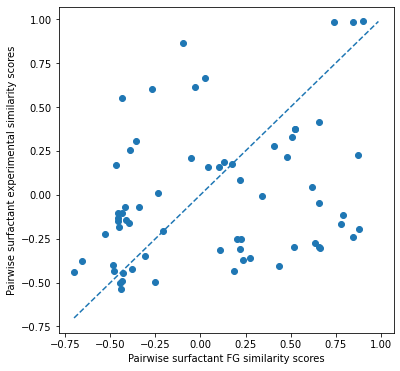

In [39]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 300

plt.figure(figsize=(6,6));
plt.scatter(avg_sim, avg_expt_sim);
plt.plot(x, x, '--');
plt.xlabel('Pairwise surfactant FG similarity scores');
plt.ylabel('Pairwise surfactant experimental similarity scores');

In [4]:
l_bounds = [8.0, 8.0, 1.0, 1.0]
u_bounds = [13.0, 13.0, 3.0, 5.0]

sampler = qmc.LatinHypercube(d=4, optimization="random-cd", seed=7)
sample = sampler.random(n=36)
LHS  = np.round(qmc.scale(sample, l_bounds, u_bounds),1)
# Conc_DoE_df = pd.DataFrame(Conc_DoE, columns=['C_S1', 'C_S2', 'C_P', 'C_T'])

In [6]:
LHS_df = pd.DataFrame(LHS, columns=['C_S1', 'C_S2', 'C_P', 'C_T'])
LHS_df

,C_S1,C_S2,C_P,C_T
0,9.3,10.5,1.3,3.2
1,8.7,8.2,2.0,3.6
2,12.3,10.3,1.0,1.9
3,12.5,12.8,1.6,4.5
4,9.9,9.4,1.3,3.8
5,11.0,8.3,1.7,4.9
6,12.1,12.3,2.0,2.3
7,12.9,9.7,2.2,4.3
8,8.9,12.5,1.4,1.4
9,11.3,9.9,1.5,1.1


In [8]:
LHS_df.to_csv('Initial_LHS.csv')